# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-25000'
TEST_DATASET_NAME = 'dataset-test'

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Dataset
from datasets import load_from_disk

class GeneratedDataset(Dataset):
    def __init__(self, name, transform=None):
        self.dataset_dict = load_from_disk(name)
        self.dataset = self.dataset_dict['train']
        self.transform = transform 
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if self.transform:
            image = self.transform(image)
        return image 
    
# Load and preprocess the dataset
transform = transforms.Compose([
    #transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

trainset = GeneratedDataset(DATASET_NAME, transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False)


## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, self.embedding_size)  # Fully connected layer to get 32-length embedding

        # Decoder
        self.fc2 = nn.Linear(self.embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.fc1(encoded)  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [4]:
def train_model(embedding_size=32, learning_rate=1e-5, weight_decay=1e-5, num_epochs=50):
    # Initialize the model, loss function, and optimizer
    model = Autoencoder(embedding_size=embedding_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Arrays to store training and testing loss
    train_losses = []
    test_losses = []

    model = model.to(device)

    # Training the autoencoder
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in trainloader:
            inputs = data.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(trainloader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data in testloader:
                inputs = data.to(device)
                outputs, _ = model(inputs)
                loss = criterion(outputs, inputs)
                test_loss += loss.item()
        
        test_loss /= len(testloader)
        test_losses.append(test_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        scheduler.step()

    # Save the model
    # torch.save(model.state_dict(), 'autoencoder.pth')
    return model, train_losses, test_losses


In [5]:
import matplotlib.pyplot as plt

def plot_model(model, train_losses, test_losses):
    # Plot the training and testing loss
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Testing Loss')
    plt.show()

    # Show some examples of reconstruction
    model.eval()
    with torch.no_grad():
        for i in range(5):  # Show 5 examples
            inputs = testset[i].unsqueeze(0)  # Add batch dimension
            inputs = inputs
            outputs, _ = model(inputs.to(device))
            outputs = outputs.to('cpu')
            
            plt.figure(figsize=(6,3))
            
            # Original Image
            plt.subplot(1,2,1)
            plt.imshow(inputs.squeeze().permute(1, 2, 0).numpy())
            plt.title('Original Image')
            
            # Reconstructed Image
            plt.subplot(1,2,2)
            plt.imshow(outputs.squeeze().permute(1, 2, 0).numpy())
            plt.title('Reconstructed Image')
            
            plt.show()

## Evaluation

Testing with embedding size of (down from 8192)
- 1024
- 512
- 256
- 128
- 64
- 32
- 16
- 8
- 4
- 2

Epoch [1/50], Train Loss: 0.5502, Test Loss: 0.3470
Epoch [2/50], Train Loss: 0.2605, Test Loss: 0.2202
Epoch [3/50], Train Loss: 0.1719, Test Loss: 0.1594
Epoch [4/50], Train Loss: 0.1484, Test Loss: 0.1497
Epoch [5/50], Train Loss: 0.1418, Test Loss: 0.1442
Epoch [6/50], Train Loss: 0.1372, Test Loss: 0.1403
Epoch [7/50], Train Loss: 0.1342, Test Loss: 0.1375
Epoch [8/50], Train Loss: 0.1317, Test Loss: 0.1353
Epoch [9/50], Train Loss: 0.1295, Test Loss: 0.1331
Epoch [10/50], Train Loss: 0.1271, Test Loss: 0.1306
Epoch [11/50], Train Loss: 0.1248, Test Loss: 0.1278
Epoch [12/50], Train Loss: 0.1214, Test Loss: 0.1228
Epoch [13/50], Train Loss: 0.1131, Test Loss: 0.1116
Epoch [14/50], Train Loss: 0.1061, Test Loss: 0.1090
Epoch [15/50], Train Loss: 0.1043, Test Loss: 0.1077
Epoch [16/50], Train Loss: 0.1031, Test Loss: 0.1067
Epoch [17/50], Train Loss: 0.1020, Test Loss: 0.1057
Epoch [18/50], Train Loss: 0.1011, Test Loss: 0.1049
Epoch [19/50], Train Loss: 0.1002, Test Loss: 0.1042
Ep

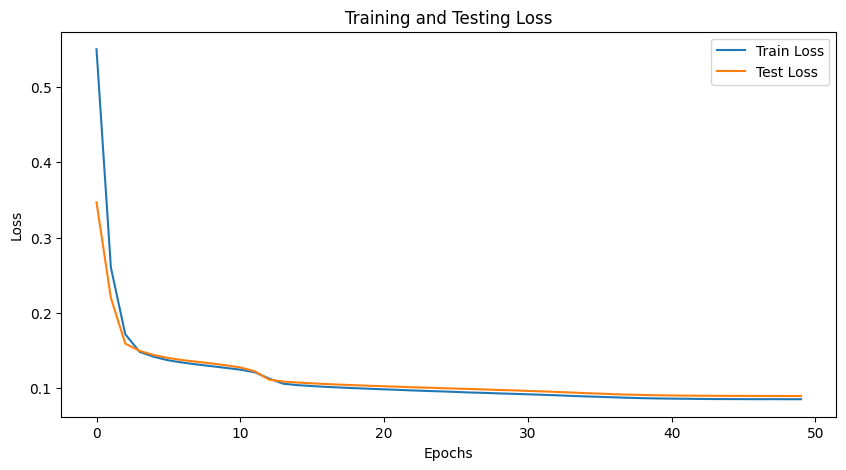

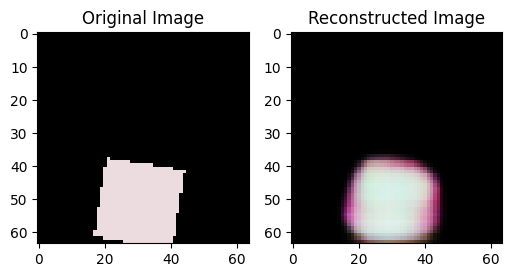

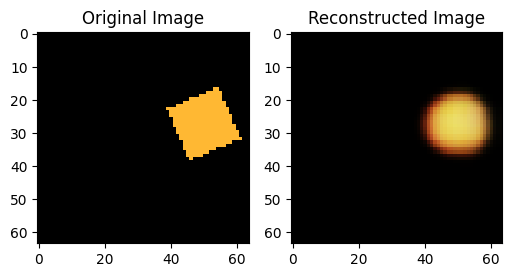

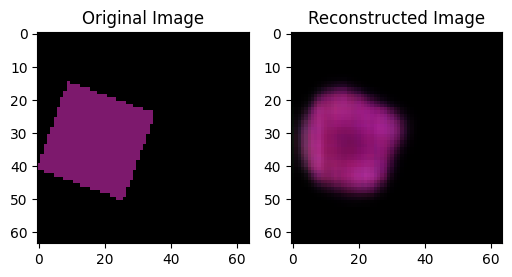

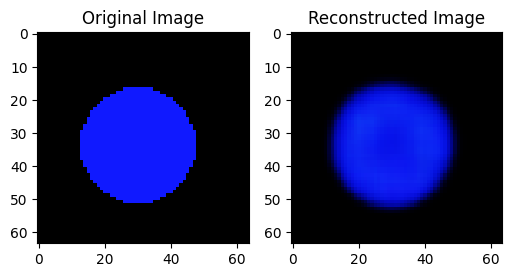

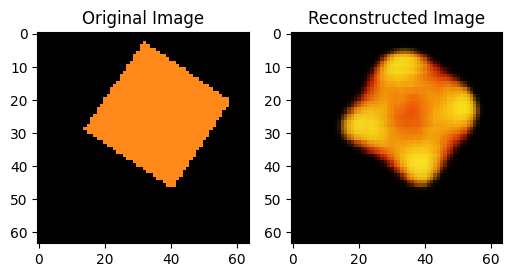

In [6]:
model, train_losses, test_losses = train_model(1024)
plot_model(model, train_losses, test_losses)

Epoch [1/50], Train Loss: 0.6072, Test Loss: 0.3973
Epoch [2/50], Train Loss: 0.3253, Test Loss: 0.2899
Epoch [3/50], Train Loss: 0.2560, Test Loss: 0.2454
Epoch [4/50], Train Loss: 0.2073, Test Loss: 0.1771
Epoch [5/50], Train Loss: 0.1590, Test Loss: 0.1578
Epoch [6/50], Train Loss: 0.1483, Test Loss: 0.1507
Epoch [7/50], Train Loss: 0.1431, Test Loss: 0.1463
Epoch [8/50], Train Loss: 0.1396, Test Loss: 0.1430
Epoch [9/50], Train Loss: 0.1368, Test Loss: 0.1405
Epoch [10/50], Train Loss: 0.1346, Test Loss: 0.1384
Epoch [11/50], Train Loss: 0.1326, Test Loss: 0.1366
Epoch [12/50], Train Loss: 0.1310, Test Loss: 0.1350
Epoch [13/50], Train Loss: 0.1294, Test Loss: 0.1335
Epoch [14/50], Train Loss: 0.1281, Test Loss: 0.1320
Epoch [15/50], Train Loss: 0.1266, Test Loss: 0.1307
Epoch [16/50], Train Loss: 0.1254, Test Loss: 0.1296
Epoch [17/50], Train Loss: 0.1242, Test Loss: 0.1283
Epoch [18/50], Train Loss: 0.1231, Test Loss: 0.1271
Epoch [19/50], Train Loss: 0.1222, Test Loss: 0.1262
Ep

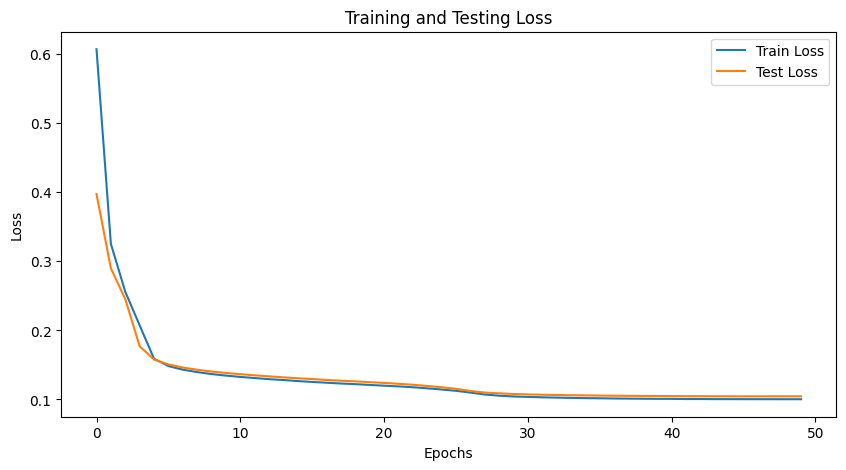

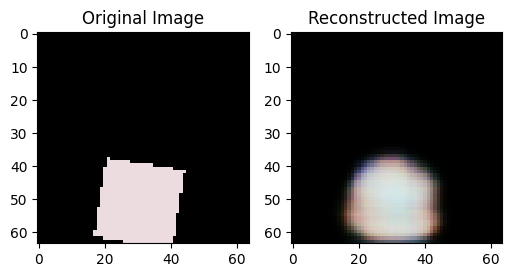

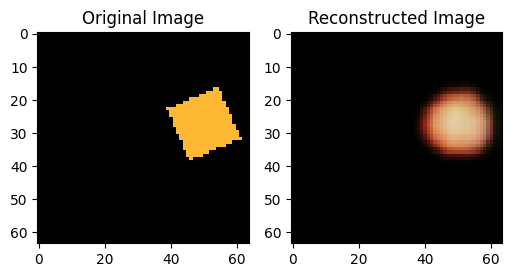

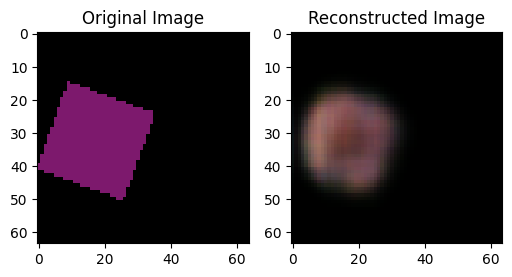

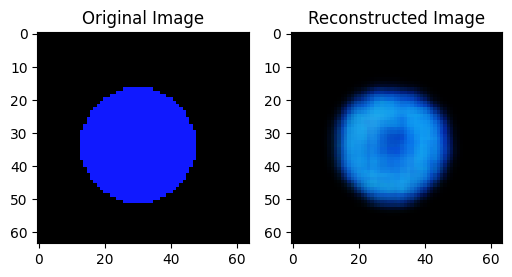

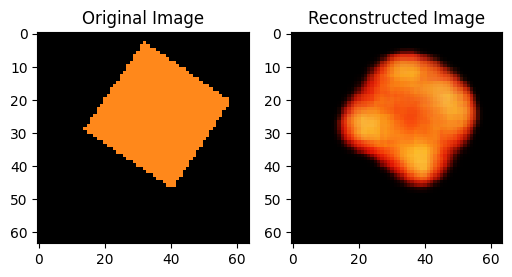

In [7]:
model, train_losses, test_losses = train_model(128)
plot_model(model, train_losses, test_losses)

Epoch [1/50], Train Loss: 0.5828, Test Loss: 0.4099
Epoch [2/50], Train Loss: 0.3366, Test Loss: 0.3040
Epoch [3/50], Train Loss: 0.2703, Test Loss: 0.2669
Epoch [4/50], Train Loss: 0.2525, Test Loss: 0.2508
Epoch [5/50], Train Loss: 0.2177, Test Loss: 0.1919
Epoch [6/50], Train Loss: 0.1656, Test Loss: 0.1596
Epoch [7/50], Train Loss: 0.1489, Test Loss: 0.1507
Epoch [8/50], Train Loss: 0.1434, Test Loss: 0.1468
Epoch [9/50], Train Loss: 0.1404, Test Loss: 0.1443
Epoch [10/50], Train Loss: 0.1384, Test Loss: 0.1424
Epoch [11/50], Train Loss: 0.1367, Test Loss: 0.1406
Epoch [12/50], Train Loss: 0.1349, Test Loss: 0.1389
Epoch [13/50], Train Loss: 0.1335, Test Loss: 0.1373
Epoch [14/50], Train Loss: 0.1319, Test Loss: 0.1359
Epoch [15/50], Train Loss: 0.1306, Test Loss: 0.1346
Epoch [16/50], Train Loss: 0.1295, Test Loss: 0.1335
Epoch [17/50], Train Loss: 0.1284, Test Loss: 0.1324
Epoch [18/50], Train Loss: 0.1274, Test Loss: 0.1315
Epoch [19/50], Train Loss: 0.1265, Test Loss: 0.1306
Ep

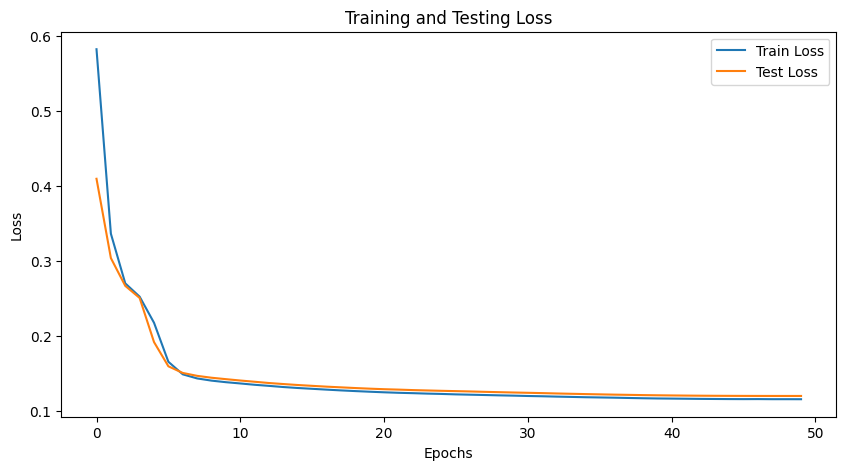

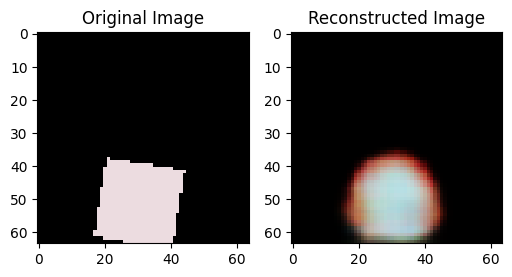

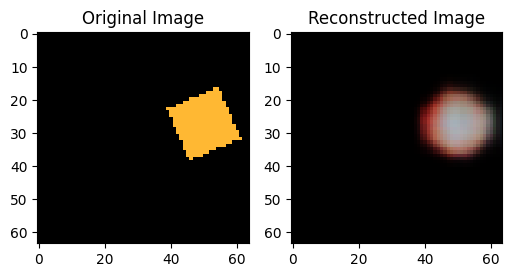

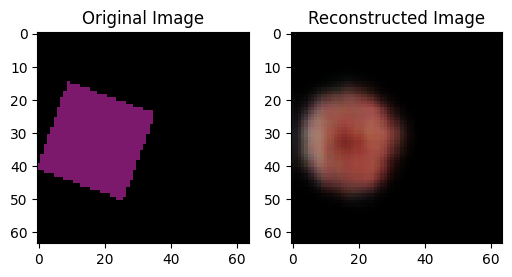

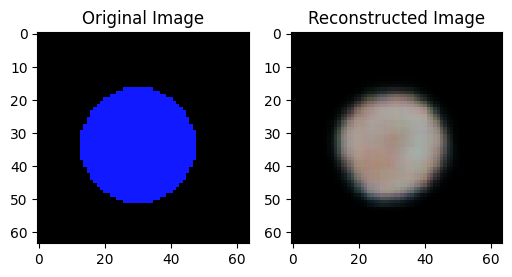

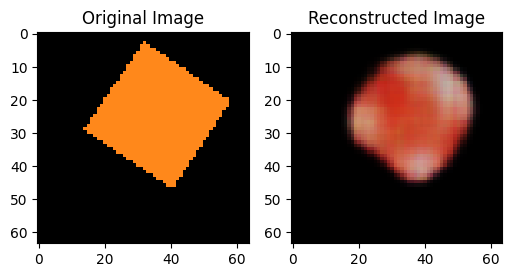

In [8]:
model, train_losses, test_losses = train_model(32)
plot_model(model, train_losses, test_losses)

Epoch [1/50], Train Loss: 0.6122, Test Loss: 0.4215
Epoch [2/50], Train Loss: 0.3321, Test Loss: 0.3004
Epoch [3/50], Train Loss: 0.2730, Test Loss: 0.2716
Epoch [4/50], Train Loss: 0.2598, Test Loss: 0.2644
Epoch [5/50], Train Loss: 0.2527, Test Loss: 0.2559
Epoch [6/50], Train Loss: 0.2408, Test Loss: 0.2352
Epoch [7/50], Train Loss: 0.1978, Test Loss: 0.1773
Epoch [8/50], Train Loss: 0.1617, Test Loss: 0.1609
Epoch [9/50], Train Loss: 0.1509, Test Loss: 0.1531
Epoch [10/50], Train Loss: 0.1454, Test Loss: 0.1489
Epoch [11/50], Train Loss: 0.1424, Test Loss: 0.1460
Epoch [12/50], Train Loss: 0.1400, Test Loss: 0.1438
Epoch [13/50], Train Loss: 0.1381, Test Loss: 0.1420
Epoch [14/50], Train Loss: 0.1365, Test Loss: 0.1404
Epoch [15/50], Train Loss: 0.1351, Test Loss: 0.1392
Epoch [16/50], Train Loss: 0.1339, Test Loss: 0.1381
Epoch [17/50], Train Loss: 0.1330, Test Loss: 0.1372
Epoch [18/50], Train Loss: 0.1321, Test Loss: 0.1364
Epoch [19/50], Train Loss: 0.1314, Test Loss: 0.1356
Ep

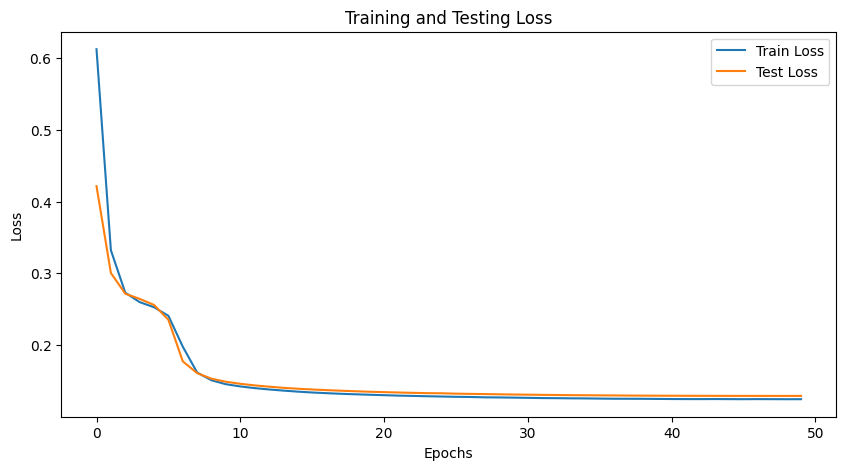

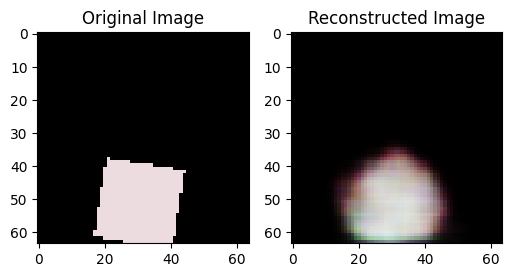

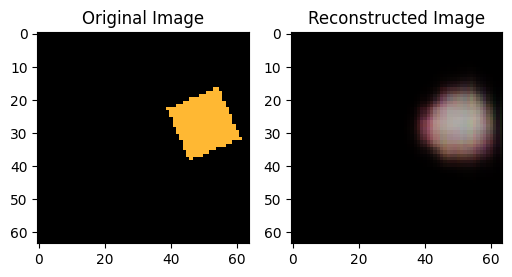

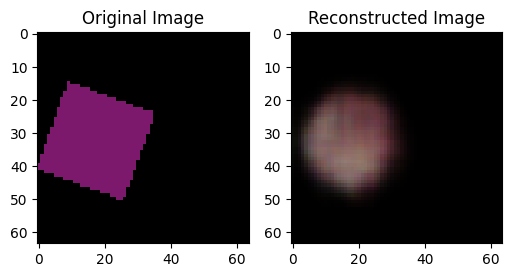

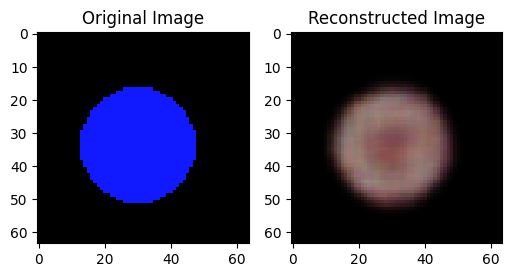

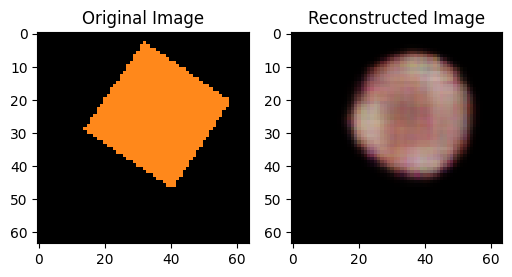

In [9]:
model, train_losses, test_losses = train_model(8)
plot_model(model, train_losses, test_losses)